In [1]:
import numpy as np
import argparse
import cv2

from tqdm import tqdm
import mahotas
import sys
sys.path.append("/Users/rcarlson/Documents/GitHub/lasagna3/snakes")
from ops.imports_ipython import *

import skimage
import umap.umap_ as umap
import stringdb
import pandas as pd

from dask import compute, delayed
from dask.distributed import Client

/Users/rcarlson/miniconda3/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Combine pretrained features

In [2]:
loc = '/home/rcarlson/mountb/m40-m42/process/xception/*.ch0.pkl'


files = natsorted(glob(loc))
    
    
# load pheno dfs
@delayed
def read_pheno(f):
        plate = f.split('feats_')[1].split('_')[0]
        well = f.split('feats_')[1].split('_')[1]
        cells = f.split('feats_')[1].split('_')[2] + '_' + f.split('feats_')[1].split('_')[3].split('.')[0]
        cellinfo = pd.read_csv('/home/rcarlson/mountb/m40-m42/process/cells_ls/%s_%s_%s.csv'%(plate, well, cells))

        plate = ['M' + s.split('/M')[1].split('/')[0] for s in cellinfo['0']]
        well = [s.split('/M')[1].split('_')[0][8:] for s in cellinfo['0']]
        site = [s.split('/M')[1].split('_')[1].split('.')[0][4:] for s in cellinfo['0']]
        cell = [s.split('/M')[1].split('.cell')[0].split('tif_')[1] for s in cellinfo['0']]

        tmp = pd.concat([pd.DataFrame([plate, well, site, cell]).transpose(), pd.read_pickle(f).astype('float16')], axis = 1)

        return tmp



from dask.diagnostics import ProgressBar
with ProgressBar():
    df = pd.concat(compute(*map(read_pheno, files), scheduler='threads'))


[########################################] | 100% Completed | 10min 21.2s


In [4]:
nchannels = 1
df.columns = ['plate', 'well', 'site', 'cell'] + ['cnn_feat' + str(c) for c in range(0,2048*nchannels)]
df.cell = df.cell.astype('int64')
df.site = df.site.astype('int64')

gene_info = pd.read_hdf('/home/rcarlson/mountb/m40-m42/df_26.hdf')

df = pd.merge(gene_info[['plate','well','cell','site','cell_barcode_0','gene']], 
         df, how = 'right', on = ['plate','well', 'cell', 'site'])

import gc
del gene_info
gc.collect()

91007

In [5]:
df.shape

(9068636, 2054)

In [6]:
import math

sample = df.sample(50000, random_state = 7)
colstd = sample.iloc[:,6:].std(axis = 0)
colmean = sample.iloc[:,6:].mean(axis = 0)
colcov = colstd/colmean

infmean = [f == math.inf for f in colmean]
to_drop = sample.columns[6:][infmean | (colmean == 0) | (colstd == 0) | (colcov < 0.1)] 
# drop features with 0 SD/mean, infmean or < 10% COV.
print('Dropping ')
print(len(to_drop)/len(sample.iloc[:,6:].columns)*100)
print('% of features')

Dropping 
49.51171875
% of features


In [7]:
df.drop(to_drop, inplace = True, axis = 1)

df.to_hdf('/home/rcarlson/mountb/m40-m42/process/misc/df_feats_ch0.hdf', key = 'x')

In [ ]:
loc = '/home/rcarlson/mountb/m40-m42/process/xception/*.ch1.pkl'


files = natsorted(glob(loc))
    
    
# load pheno dfs
@delayed
def read_pheno(f):
        plate = f.split('feats_')[1].split('_')[0]
        well = f.split('feats_')[1].split('_')[1]
        cells = f.split('feats_')[1].split('_')[2] + '_' + f.split('feats_')[1].split('_')[3].split('.')[0]
        cellinfo = pd.read_csv('/home/rcarlson/mountb/m40-m42/process/cells_ls/%s_%s_%s.csv'%(plate, well, cells))

        plate = ['M' + s.split('/M')[1].split('/')[0] for s in cellinfo['0']]
        well = [s.split('/M')[1].split('_')[0][8:] for s in cellinfo['0']]
        site = [s.split('/M')[1].split('_')[1].split('.')[0][4:] for s in cellinfo['0']]
        cell = [s.split('/M')[1].split('.cell')[0].split('tif_')[1] for s in cellinfo['0']]

        tmp = pd.concat([pd.DataFrame([plate, well, site, cell]).transpose(), pd.read_pickle(f).astype('float16')], axis = 1)

        return tmp



from dask.diagnostics import ProgressBar
with ProgressBar():
    df = pd.concat(compute(*map(read_pheno, files), scheduler='threads'))


nchannels = 1
df.columns = ['plate', 'well', 'site', 'cell'] + ['cnn_feat' + str(c) for c in range(0,2048*nchannels)]
df.cell = df.cell.astype('int64')
df.site = df.site.astype('int64')

gene_info = pd.read_hdf('/home/rcarlson/mountb/m40-m42/df_26.hdf')

df = pd.merge(gene_info[['plate','well','cell','site','cell_barcode_0','gene']], 
         df, how = 'right', on = ['plate','well', 'cell', 'site'])

import gc
del gene_info
gc.collect()

import math

sample = df.sample(50000, random_state = 7)
colstd = sample.iloc[:,6:].std(axis = 0)
colmean = sample.iloc[:,6:].mean(axis = 0)
colcov = colstd/colmean

infmean = [f == math.inf for f in colmean]
to_drop = sample.columns[6:][infmean | (colmean == 0) | (colstd == 0) | (colcov < 0.1)] 
# drop features with 0 SD/mean, infmean or < 10% COV.
print('Dropping ')
print(len(to_drop)/len(sample.iloc[:,6:].columns)*100)
print('% of features')

df.drop(to_drop, inplace = True, axis = 1)

df.to_hdf('/home/rcarlson/mountb/m40-m42/process/misc/df_feats_ch1.hdf', key = 'x')

[###                                     ] | 9% Completed |  1min  9.8s

In [ ]:
loc = '/home/rcarlson/mountb/m40-m42/process/xception/*.ch2.pkl'


files = natsorted(glob(loc))
    
    
# load pheno dfs
@delayed
def read_pheno(f):
        plate = f.split('feats_')[1].split('_')[0]
        well = f.split('feats_')[1].split('_')[1]
        cells = f.split('feats_')[1].split('_')[2] + '_' + f.split('feats_')[1].split('_')[3].split('.')[0]
        cellinfo = pd.read_csv('/home/rcarlson/mountb/m40-m42/process/cells_ls/%s_%s_%s.csv'%(plate, well, cells))

        plate = ['M' + s.split('/M')[1].split('/')[0] for s in cellinfo['0']]
        well = [s.split('/M')[1].split('_')[0][8:] for s in cellinfo['0']]
        site = [s.split('/M')[1].split('_')[1].split('.')[0][4:] for s in cellinfo['0']]
        cell = [s.split('/M')[1].split('.cell')[0].split('tif_')[1] for s in cellinfo['0']]

        tmp = pd.concat([pd.DataFrame([plate, well, site, cell]).transpose(), pd.read_pickle(f).astype('float16')], axis = 1)

        return tmp



from dask.diagnostics import ProgressBar
with ProgressBar():
    df = pd.concat(compute(*map(read_pheno, files), scheduler='threads'))


nchannels = 1
df.columns = ['plate', 'well', 'site', 'cell'] + ['cnn_feat' + str(c) for c in range(0,2048*nchannels)]
df.cell = df.cell.astype('int64')
df.site = df.site.astype('int64')

gene_info = pd.read_hdf('/home/rcarlson/mountb/m40-m42/df_26.hdf')

df = pd.merge(gene_info[['plate','well','cell','site','cell_barcode_0','gene']], 
         df, how = 'right', on = ['plate','well', 'cell', 'site'])

import gc
del gene_info
gc.collect()

import math

sample = df.sample(50000, random_state = 7)
colstd = sample.iloc[:,6:].std(axis = 0)
colmean = sample.iloc[:,6:].mean(axis = 0)
colcov = colstd/colmean

infmean = [f == math.inf for f in colmean]
to_drop = sample.columns[6:][infmean | (colmean == 0) | (colstd == 0) | (colcov < 0.1)] 
# drop features with 0 SD/mean, infmean or < 10% COV.
print('Dropping ')
print(len(to_drop)/len(sample.iloc[:,6:].columns)*100)
print('% of features')

df.drop(to_drop, inplace = True, axis = 1)

df.to_hdf('/home/rcarlson/mountb/m40-m42/process/misc/df_feats_ch2.hdf', key = 'x')




loc = '/home/rcarlson/mountb/m40-m42/process/xception/*.ch3.pkl'


files = natsorted(glob(loc))
    
    
# load pheno dfs
@delayed
def read_pheno(f):
        plate = f.split('feats_')[1].split('_')[0]
        well = f.split('feats_')[1].split('_')[1]
        cells = f.split('feats_')[1].split('_')[2] + '_' + f.split('feats_')[1].split('_')[3].split('.')[0]
        cellinfo = pd.read_csv('/home/rcarlson/mountb/m40-m42/process/cells_ls/%s_%s_%s.csv'%(plate, well, cells))

        plate = ['M' + s.split('/M')[1].split('/')[0] for s in cellinfo['0']]
        well = [s.split('/M')[1].split('_')[0][8:] for s in cellinfo['0']]
        site = [s.split('/M')[1].split('_')[1].split('.')[0][4:] for s in cellinfo['0']]
        cell = [s.split('/M')[1].split('.cell')[0].split('tif_')[1] for s in cellinfo['0']]

        tmp = pd.concat([pd.DataFrame([plate, well, site, cell]).transpose(), pd.read_pickle(f).astype('float16')], axis = 1)

        return tmp



from dask.diagnostics import ProgressBar
with ProgressBar():
    df = pd.concat(compute(*map(read_pheno, files), scheduler='threads'))


nchannels = 1
df.columns = ['plate', 'well', 'site', 'cell'] + ['cnn_feat' + str(c) for c in range(0,2048*nchannels)]
df.cell = df.cell.astype('int64')
df.site = df.site.astype('int64')

gene_info = pd.read_hdf('/home/rcarlson/mountb/m40-m42/df_26.hdf')

df = pd.merge(gene_info[['plate','well','cell','site','cell_barcode_0','gene']], 
         df, how = 'right', on = ['plate','well', 'cell', 'site'])

import gc
del gene_info
gc.collect()

import math

sample = df.sample(50000, random_state = 7)
colstd = sample.iloc[:,6:].std(axis = 0)
colmean = sample.iloc[:,6:].mean(axis = 0)
colcov = colstd/colmean

infmean = [f == math.inf for f in colmean]
to_drop = sample.columns[6:][infmean | (colmean == 0) | (colstd == 0) | (colcov < 0.1)] 
# drop features with 0 SD/mean, infmean or < 10% COV.
print('Dropping ')
print(len(to_drop)/len(sample.iloc[:,6:].columns)*100)
print('% of features')

df.drop(to_drop, inplace = True, axis = 1)

df.to_hdf('/home/rcarlson/mountb/m40-m42/process/misc/df_feats_ch3.hdf', key = 'x')

In [ ]:
loc = '/home/rcarlson/mountb/m40-m42/process/xception/*.ch4.pkl'


files = natsorted(glob(loc))
    
    
# load pheno dfs
@delayed
def read_pheno(f):
        plate = f.split('feats_')[1].split('_')[0]
        well = f.split('feats_')[1].split('_')[1]
        cells = f.split('feats_')[1].split('_')[2] + '_' + f.split('feats_')[1].split('_')[3].split('.')[0]
        cellinfo = pd.read_csv('/home/rcarlson/mountb/m40-m42/process/cells_ls/%s_%s_%s.csv'%(plate, well, cells))

        plate = ['M' + s.split('/M')[1].split('/')[0] for s in cellinfo['0']]
        well = [s.split('/M')[1].split('_')[0][8:] for s in cellinfo['0']]
        site = [s.split('/M')[1].split('_')[1].split('.')[0][4:] for s in cellinfo['0']]
        cell = [s.split('/M')[1].split('.cell')[0].split('tif_')[1] for s in cellinfo['0']]

        tmp = pd.concat([pd.DataFrame([plate, well, site, cell]).transpose(), pd.read_pickle(f).astype('float16')], axis = 1)

        return tmp



from dask.diagnostics import ProgressBar
with ProgressBar():
    df = pd.concat(compute(*map(read_pheno, files), scheduler='threads'))


nchannels = 1
df.columns = ['plate', 'well', 'site', 'cell'] + ['cnn_feat' + str(c) for c in range(0,2048*nchannels)]
df.cell = df.cell.astype('int64')
df.site = df.site.astype('int64')

gene_info = pd.read_hdf('/home/rcarlson/mountb/m40-m42/df_26.hdf')

df = pd.merge(gene_info[['plate','well','cell','site','cell_barcode_0','gene']], 
         df, how = 'right', on = ['plate','well', 'cell', 'site'])

import gc
del gene_info
gc.collect()

import math

sample = df.sample(50000, random_state = 7)
colstd = sample.iloc[:,6:].std(axis = 0)
colmean = sample.iloc[:,6:].mean(axis = 0)
colcov = colstd/colmean

infmean = [f == math.inf for f in colmean]
to_drop = sample.columns[6:][infmean | (colmean == 0) | (colstd == 0) | (colcov < 0.1)] 
# drop features with 0 SD/mean, infmean or < 10% COV.
print('Dropping ')
print(len(to_drop)/len(sample.iloc[:,6:].columns)*100)
print('% of features')

df.drop(to_drop, inplace = True, axis = 1)

df.to_hdf('/home/rcarlson/mountb/m40-m42/process/misc/df_feats_ch4.hdf', key = 'x')




loc = '/home/rcarlson/mountb/m40-m42/process/xception/*.ch5.pkl'


files = natsorted(glob(loc))
    
    
# load pheno dfs
@delayed
def read_pheno(f):
        plate = f.split('feats_')[1].split('_')[0]
        well = f.split('feats_')[1].split('_')[1]
        cells = f.split('feats_')[1].split('_')[2] + '_' + f.split('feats_')[1].split('_')[3].split('.')[0]
        cellinfo = pd.read_csv('/home/rcarlson/mountb/m40-m42/process/cells_ls/%s_%s_%s.csv'%(plate, well, cells))

        plate = ['M' + s.split('/M')[1].split('/')[0] for s in cellinfo['0']]
        well = [s.split('/M')[1].split('_')[0][8:] for s in cellinfo['0']]
        site = [s.split('/M')[1].split('_')[1].split('.')[0][4:] for s in cellinfo['0']]
        cell = [s.split('/M')[1].split('.cell')[0].split('tif_')[1] for s in cellinfo['0']]

        tmp = pd.concat([pd.DataFrame([plate, well, site, cell]).transpose(), pd.read_pickle(f).astype('float16')], axis = 1)

        return tmp



from dask.diagnostics import ProgressBar
with ProgressBar():
    df = pd.concat(compute(*map(read_pheno, files), scheduler='threads'))


nchannels = 1
df.columns = ['plate', 'well', 'site', 'cell'] + ['cnn_feat' + str(c) for c in range(0,2048*nchannels)]
df.cell = df.cell.astype('int64')
df.site = df.site.astype('int64')

gene_info = pd.read_hdf('/home/rcarlson/mountb/m40-m42/df_26.hdf')

df = pd.merge(gene_info[['plate','well','cell','site','cell_barcode_0','gene']], 
         df, how = 'right', on = ['plate','well', 'cell', 'site'])

import gc
del gene_info
gc.collect()

import math

sample = df.sample(50000, random_state = 7)
colstd = sample.iloc[:,6:].std(axis = 0)
colmean = sample.iloc[:,6:].mean(axis = 0)
colcov = colstd/colmean

infmean = [f == math.inf for f in colmean]
to_drop = sample.columns[6:][infmean | (colmean == 0) | (colstd == 0) | (colcov < 0.1)] 
# drop features with 0 SD/mean, infmean or < 10% COV.
print('Dropping ')
print(len(to_drop)/len(sample.iloc[:,6:].columns)*100)
print('% of features')

df.drop(to_drop, inplace = True, axis = 1)

df.to_hdf('/home/rcarlson/mountb/m40-m42/process/misc/df_feats_ch5.hdf', key = 'x')



loc = '/home/rcarlson/mountb/m40-m42/process/xception/*.ch6.pkl'


files = natsorted(glob(loc))
    
    
# load pheno dfs
@delayed
def read_pheno(f):
        plate = f.split('feats_')[1].split('_')[0]
        well = f.split('feats_')[1].split('_')[1]
        cells = f.split('feats_')[1].split('_')[2] + '_' + f.split('feats_')[1].split('_')[3].split('.')[0]
        cellinfo = pd.read_csv('/home/rcarlson/mountb/m40-m42/process/cells_ls/%s_%s_%s.csv'%(plate, well, cells))

        plate = ['M' + s.split('/M')[1].split('/')[0] for s in cellinfo['0']]
        well = [s.split('/M')[1].split('_')[0][8:] for s in cellinfo['0']]
        site = [s.split('/M')[1].split('_')[1].split('.')[0][4:] for s in cellinfo['0']]
        cell = [s.split('/M')[1].split('.cell')[0].split('tif_')[1] for s in cellinfo['0']]

        tmp = pd.concat([pd.DataFrame([plate, well, site, cell]).transpose(), pd.read_pickle(f).astype('float16')], axis = 1)

        return tmp



from dask.diagnostics import ProgressBar
with ProgressBar():
    df = pd.concat(compute(*map(read_pheno, files), scheduler='threads'))


nchannels = 1
df.columns = ['plate', 'well', 'site', 'cell'] + ['cnn_feat' + str(c) for c in range(0,2048*nchannels)]
df.cell = df.cell.astype('int64')
df.site = df.site.astype('int64')

gene_info = pd.read_hdf('/home/rcarlson/mountb/m40-m42/df_26.hdf')

df = pd.merge(gene_info[['plate','well','cell','site','cell_barcode_0','gene']], 
         df, how = 'right', on = ['plate','well', 'cell', 'site'])

import gc
del gene_info
gc.collect()

import math

sample = df.sample(50000, random_state = 7)
colstd = sample.iloc[:,6:].std(axis = 0)
colmean = sample.iloc[:,6:].mean(axis = 0)
colcov = colstd/colmean

infmean = [f == math.inf for f in colmean]
to_drop = sample.columns[6:][infmean | (colmean == 0) | (colstd == 0) | (colcov < 0.1)] 
# drop features with 0 SD/mean, infmean or < 10% COV.
print('Dropping ')
print(len(to_drop)/len(sample.iloc[:,6:].columns)*100)
print('% of features')

df.drop(to_drop, inplace = True, axis = 1)

df.to_hdf('/home/rcarlson/mountb/m40-m42/process/misc/df_feats_ch6.hdf', key = 'x')

## Exploratory analysis

In [9]:

df = pd.read_hdf('/home/rcarlson/mountb/m40-m42/process/misc/df_feats_ch2.hdf', key = 'x')

In [14]:
df.query('well == "B3"')

,well,cell,site,cell_barcode_0,gene,plate,cnn_feat1,cnn_feat2,cnn_feat3,cnn_feat4,...,cnn_feat2034,cnn_feat2035,cnn_feat2037,cnn_feat2038,cnn_feat2041,cnn_feat2043,cnn_feat2044,cnn_feat2045,cnn_feat2046,cnn_feat2047
18218927,B3,664,1280,GGTAGCGCACGC,ANKRD16,M42B,0.089844,0.015152,0.0,0.0,...,0.332275,0.000600,0.0,0.0,0.0000,0.0,0.0,0.094849,0.007092,0.0
18218928,B3,666,1280,CCGGCCCAGCGT,BCL2L12,M42B,0.039185,0.014893,0.0,0.0,...,0.515137,0.025406,0.0,0.0,0.0000,0.0,0.0,0.090576,0.001328,0.0
18218929,B3,667,1280,TGAGCTCATGCT,TMEM25,M42B,0.041046,0.015167,0.0,0.0,...,0.513184,0.025452,0.0,0.0,0.0000,0.0,0.0,0.091125,0.001519,0.0
18218930,B3,684,1280,CAGGATGGCAGC,ZNF543,M42B,0.104553,0.010651,0.0,0.0,...,0.267334,0.000299,0.0,0.0,0.0002,0.0,0.0,0.105591,0.010040,0.0
18218931,B3,687,1280,TGCGCGTACTCC,HOXA4,M42B,0.034180,0.014587,0.0,0.0,...,0.519043,0.026337,0.0,0.0,0.0000,0.0,0.0,0.090454,0.000909,0.0


In [3]:
df.shape[0]/2

NameError: name 'df' is not defined

In [2]:
grped = df.groupby(['gene']).median().reset_index()



NameError: name 'df' is not defined

In [153]:
grped.iloc[1000:,2:]

,cnn_feat1,cnn_feat2,cnn_feat3,cnn_feat4,cnn_feat10,cnn_feat12,cnn_feat13,cnn_feat15,cnn_feat16,cnn_feat17,...,cnn_feat2034,cnn_feat2035,cnn_feat2037,cnn_feat2038,cnn_feat2041,cnn_feat2043,cnn_feat2044,cnn_feat2045,cnn_feat2046,cnn_feat2047
1000,0.074036,0.018723,0.0,0.0,0.0,0.0,0.067383,0.172119,0.0,0.002373,...,0.401855,0.009300,0.0,0.0,0.0,0.0,0.0,0.090698,0.005554,0.0
1001,0.071167,0.018478,0.0,0.0,0.0,0.0,0.073181,0.166992,0.0,0.002613,...,0.418945,0.009628,0.0,0.0,0.0,0.0,0.0,0.090576,0.005112,0.0
1002,0.068542,0.018524,0.0,0.0,0.0,0.0,0.076355,0.161865,0.0,0.002594,...,0.429688,0.009193,0.0,0.0,0.0,0.0,0.0,0.090454,0.004936,0.0
1003,0.072754,0.018646,0.0,0.0,0.0,0.0,0.068787,0.171387,0.0,0.002396,...,0.410645,0.008133,0.0,0.0,0.0,0.0,0.0,0.090393,0.005390,0.0
1004,0.071289,0.018692,0.0,0.0,0.0,0.0,0.072388,0.161865,0.0,0.002438,...,0.419189,0.009445,0.0,0.0,0.0,0.0,0.0,0.090576,0.004955,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19928,0.074585,0.018753,0.0,0.0,0.0,0.0,0.071594,0.176514,0.0,0.002438,...,0.400879,0.009216,0.0,0.0,0.0,0.0,0.0,0.090637,0.005562,0.0
19929,0.070435,0.018661,0.0,0.0,0.0,0.0,0.069702,0.165771,0.0,0.002337,...,0.425049,0.008888,0.0,0.0,0.0,0.0,0.0,0.090393,0.005081,0.0
19930,0.073792,0.018982,0.0,0.0,0.0,0.0,0.066650,0.170898,0.0,0.002398,...,0.408447,0.008667,0.0,0.0,0.0,0.0,0.0,0.090576,0.005470,0.0
19931,0.071228,0.018494,0.0,0.0,0.0,0.0,0.074890,0.169556,0.0,0.002699,...,0.418945,0.010208,0.0,0.0,0.0,0.0,0.0,0.090454,0.005238,0.0


In [167]:
    
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scaler = StandardScaler()

pca = PCA(n_components = 2, svd_solver='full')
embedding = pca.fit_transform(grped.iloc[:,2:])

In [ ]:
# import umap.umap_ as umap
# embedding = umap.UMAP(n_neighbors=20,
#                       min_dist=0.01,
#                       metric='euclidean', random_state = 7).fit_transform(pcs) # 





dfu = pd.concat([pd.DataFrame(embedding),grped.gene],axis = 1)
dfu.columns = ['UMAP1','UMAP2','gene_symbol']


## much better than below since this is channel 3 only 
plt.figure(figsize = (5,5))
sns.scatterplot(data = dfu, x = 'UMAP1',  y = 'UMAP2', alpha = .2)
#genes = dfu[(dfu.UMAP1 < 6) & (dfu.UMAP2 < 1)].gene_symbol
genes = ['MAVS','DDX58', 'IRF3', 'IRF2', 'ATP13A1','RNF135']
sns.scatterplot(data = dfu[dfu.gene_symbol.isin(genes)], x = 'UMAP1', 
                    y = 'UMAP2', color = 'r')#,   legend = 'full', hue = 'gene_symbol')

sevgenes = ['SLC35A1','GNE','CMAS','COG7']#,'CAPN15','MED16','MED24','TADA2B','MAU2']
sns.scatterplot(data = dfu[dfu.gene_symbol.isin(sevgenes)], x = 'UMAP1', 
                    y = 'UMAP2', color = 'm')#,   legend = 'full', hue = 'gene_symbol')


upgenes = ['MED16', 'MED24', 'MAU2', 'LAMTOR2', 'LAMTOR3', 'LAMTOR4', 'TADA2B']#,'CAPN15','MED16','MED24','TADA2B','MAU2']
sns.scatterplot(data = dfu[dfu.gene_symbol.isin(upgenes)], x = 'UMAP1', 
                    y = 'UMAP2', color = 'b')#,   legend = 'full', hue = 'gene_symbol')


# plt.savefig('/home/rcarlson/mountb/M57/process/figs/umap_all.tif', dpi = 100, bbox_inches = 'tight')

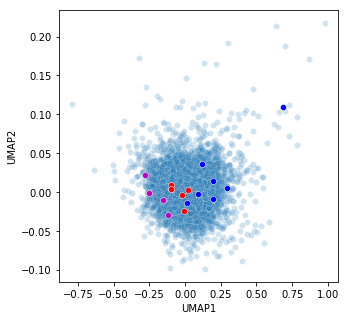

In [160]:
pcs.shape

(19933, 100)

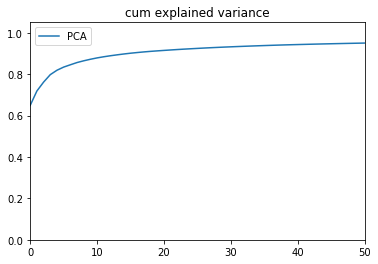

In [17]:
# plt.plot(np.cumsum(pca_nt.explained_variance_ratio_,axis = 0),label = 'tvn')
# plt.plot(np.cumsum(pca_all.explained_variance_ratio_,axis = 0),label = 'reg')
plt.plot(np.cumsum(pca.explained_variance_ratio_,axis = 0),label = 'PCA')

plt.title('cum explained variance')
plt.legend()
plt.ylim(0,1.05)
plt.xlim(0,50)
plt.show()

In [4]:
channel = 0
ch0_feats = ['cnn_feat' + str(c) for c in range(2048*channel,2048*(channel+1))]
channel = 1
ch1_feats = ['cnn_feat' + str(c) for c in range(2048*channel,2048*(channel+1))]
channel = 2
ch2_feats = ['cnn_feat' + str(c) for c in range(2048*channel,2048*(channel+1))]
channel = 3
ch3_feats = ['cnn_feat' + str(c) for c in range(2048*channel,2048*(channel+1))]



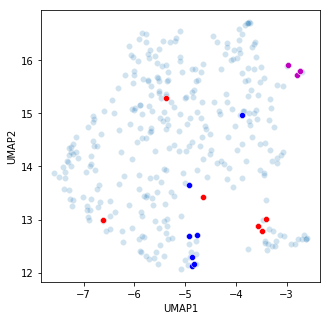

In [243]:
embedding = umap.UMAP(n_neighbors=20,
                      min_dist=0.01,
                      metric='euclidean', 
                      random_state = 7).fit_transform(grped.loc[:,grped.columns.isin(ch0_feats)]) # 





dfu = pd.concat([pd.DataFrame(embedding),grped.gene_symbol],axis = 1)
dfu.columns = ['UMAP1','UMAP2','gene_symbol']


## much better than below since this is channel 3 only 
plt.figure(figsize = (5,5))
sns.scatterplot(data = dfu, x = 'UMAP1',  y = 'UMAP2', alpha = .2)
genes = dfu[(dfu.UMAP1 < 6) & (dfu.UMAP2 < 1)].gene_symbol
genes = ['MAVS','DDX58', 'IRF3', 'IRF2', 'ATP13A1','RNF135']
sns.scatterplot(data = dfu[dfu.gene_symbol.isin(genes)], x = 'UMAP1', 
                    y = 'UMAP2', color = 'r')#,   legend = 'full', hue = 'gene_symbol')

sevgenes = ['SLC35A1','GNE','CMAS','COG7']#,'CAPN15','MED16','MED24','TADA2B','MAU2']
sns.scatterplot(data = dfu[dfu.gene_symbol.isin(sevgenes)], x = 'UMAP1', 
                    y = 'UMAP2', color = 'm')#,   legend = 'full', hue = 'gene_symbol')


upgenes = ['MED16', 'MED24', 'MAU2', 'LAMTOR2', 'LAMTOR3', 'LAMTOR4', 'TADA2B']#,'CAPN15','MED16','MED24','TADA2B','MAU2']
sns.scatterplot(data = dfu[dfu.gene_symbol.isin(upgenes)], x = 'UMAP1', 
                    y = 'UMAP2', color = 'b')#,   legend = 'full', hue = 'gene_symbol')



plt.savefig('/home/rcarlson/mountb/M57/process/figs/ch0_naive.tif', dpi = 100, bbox_inches = 'tight')

In [245]:
genes = list(dfu[(dfu.UMAP1 > -4) & (dfu.UMAP2 < 13.2)].gene_symbol)

[print(g) for g in genes]

ACTR6
CABIN1
DDX58
DPH6
EIF3G
ELF2
FBXO11
FBXW7
FZR1
IKBKG
LIN37
LIN52
LIN54
MAVS
NCOA5
RAPGEF1
RNF135
SCAF8
SLC30A1
TRIP12
UBAP2L
UBE2D2
UBE2D3
VHL


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

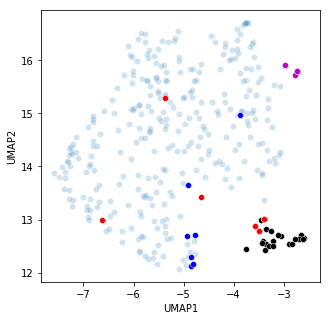

In [246]:
embedding = umap.UMAP(n_neighbors=20,
                      min_dist=0.01,
                      metric='euclidean', 
                      random_state = 7).fit_transform(grped.loc[:,grped.columns.isin(ch0_feats)]) # 





dfu = pd.concat([pd.DataFrame(embedding),grped.gene_symbol],axis = 1)
dfu.columns = ['UMAP1','UMAP2','gene_symbol']


## much better than below since this is channel 3 only 
plt.figure(figsize = (5,5))
sns.scatterplot(data = dfu, x = 'UMAP1',  y = 'UMAP2', alpha = .2)
sns.scatterplot(data = dfu[dfu.gene_symbol.isin(genes)], x = 'UMAP1', 
                    y = 'UMAP2', color = 'k')#,   legend = 'full', hue = 'gene_symbol')

downgenes = ['MAVS','DDX58', 'IRF3', 'IRF2', 'ATP13A1','RNF135']

sns.scatterplot(data = dfu[dfu.gene_symbol.isin(downgenes)], x = 'UMAP1', 
                    y = 'UMAP2', color = 'r')#,   legend = 'full', hue = 'gene_symbol')




sevgenes = ['SLC35A1','GNE','CMAS','COG7']#,'CAPN15','MED16','MED24','TADA2B','MAU2']
sns.scatterplot(data = dfu[dfu.gene_symbol.isin(sevgenes)], x = 'UMAP1', 
                    y = 'UMAP2', color = 'm')#,   legend = 'full', hue = 'gene_symbol')


upgenes = ['MED16', 'MED24', 'MAU2', 'LAMTOR2', 'LAMTOR3', 'LAMTOR4', 'TADA2B']#,'CAPN15','MED16','MED24','TADA2B','MAU2']
sns.scatterplot(data = dfu[dfu.gene_symbol.isin(upgenes)], x = 'UMAP1', 
                    y = 'UMAP2', color = 'b')#,   legend = 'full', hue = 'gene_symbol')



plt.savefig('/home/rcarlson/mountb/M57/process/figs/ch0.tif', dpi = 100, bbox_inches = 'tight')

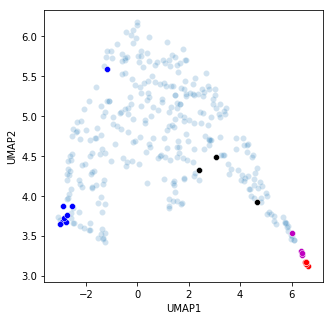

In [260]:
import umap.umap_ as umap
embedding = umap.UMAP(n_neighbors=20,
                      min_dist=0.01,
                      metric='euclidean', random_state = 7).fit_transform(grped.iloc[:,3:]) # 





dfu = pd.concat([pd.DataFrame(embedding),grped.gene_symbol],axis = 1)
dfu.columns = ['UMAP1','UMAP2','gene_symbol']


## much better than below since this is channel 3 only 
plt.figure(figsize = (5,5))
sns.scatterplot(data = dfu, x = 'UMAP1',  y = 'UMAP2', alpha = .2)
#genes = dfu[(dfu.UMAP1 < 6) & (dfu.UMAP2 < 1)].gene_symbol
downgenes = ['MAVS','DDX58', 'IRF3', 'IRF2', 'ATP13A1','RNF135']
sns.scatterplot(data = dfu[dfu.gene_symbol.isin(downgenes)], x = 'UMAP1', 
                    y = 'UMAP2', color = 'r')#,   legend = 'full', hue = 'gene_symbol')

sns.scatterplot(data = dfu[dfu.gene_symbol.isin(['UBE2D3', 'UBE2D2','TRIP12'])], x = 'UMAP1', 
                    y = 'UMAP2', color = 'k')#,   legend = 'full', hue = 'gene_symbol')



sevgenes = ['SLC35A1','GNE','CMAS','COG7']#,'CAPN15','MED16','MED24','TADA2B','MAU2']
sns.scatterplot(data = dfu[dfu.gene_symbol.isin(sevgenes)], x = 'UMAP1', 
                    y = 'UMAP2', color = 'm')#,   legend = 'full', hue = 'gene_symbol')


upgenes = ['MED16', 'MED24', 'MAU2', 'LAMTOR2', 'LAMTOR3', 'LAMTOR4', 'TADA2B']#,'CAPN15','MED16','MED24','TADA2B','MAU2']
sns.scatterplot(data = dfu[dfu.gene_symbol.isin(upgenes)], x = 'UMAP1', 
                    y = 'UMAP2', color = 'b')#,   legend = 'full', hue = 'gene_symbol')


plt.show()
#plt.savefig('/home/rcarlson/mountb/M57/process/figs/umap_all.tif', dpi = 100, bbox_inches = 'tight')

In [177]:
df_all.groupby(['cell_barcode_0', 'gene_symbol']).cell.count().describe()

count    1927.000000
mean      235.520498
std       204.037923
min        32.000000
25%       110.000000
50%       185.000000
75%       291.000000
max      1987.000000
Name: cell, dtype: float64

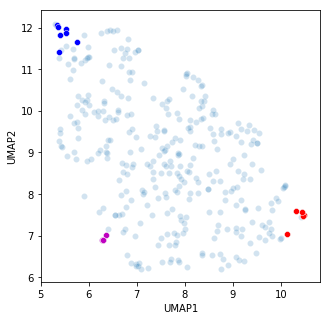

In [5]:
embedding = umap.UMAP(n_neighbors=10,
                      min_dist=0.05,
                      metric='euclidean', 
                      random_state = 7).fit_transform(grped.loc[:,grped.columns.isin(ch3_feats)]) # 





dfu = pd.concat([pd.DataFrame(embedding),grped.gene_symbol],axis = 1)
dfu.columns = ['UMAP1','UMAP2','gene_symbol']


## much better than below since this is channel 3 only 
plt.figure(figsize = (5,5))
sns.scatterplot(data = dfu, x = 'UMAP1',  y = 'UMAP2', alpha = .2)
#genes = dfu[(dfu.UMAP1 < 6) & (dfu.UMAP2 < 1)].gene_symbol
# sns.scatterplot(data = dfu[dfu.gene_symbol.isin(genes)], x = 'UMAP1', 
#                     y = 'UMAP2', color = 'k')#,   legend = 'full', hue = 'gene_symbol')

downgenes = ['MAVS','DDX58', 'IRF3', 'IRF2', 'ATP13A1','RNF135']

sns.scatterplot(data = dfu[dfu.gene_symbol.isin(downgenes)], x = 'UMAP1', 
                    y = 'UMAP2', color = 'r')#,   legend = 'full', hue = 'gene_symbol')




sevgenes = ['SLC35A1','GNE','CMAS','COG7']#,'CAPN15','MED16','MED24','TADA2B','MAU2']
sns.scatterplot(data = dfu[dfu.gene_symbol.isin(sevgenes)], x = 'UMAP1', 
                    y = 'UMAP2', color = 'm')#,   legend = 'full', hue = 'gene_symbol')


upgenes = ['MED16', 'MED24', 'MAU2', 'LAMTOR2', 'LAMTOR3', 'LAMTOR4', 'TADA2B']#,'CAPN15','MED16','MED24','TADA2B','MAU2']
sns.scatterplot(data = dfu[dfu.gene_symbol.isin(upgenes)], x = 'UMAP1', 
                    y = 'UMAP2', color = 'b')#,   legend = 'full', hue = 'gene_symbol')



plt.savefig('/home/rcarlson/mountb/M57/process/figs/ch3.tif', dpi = 100, bbox_inches = 'tight')

In [7]:
[print(g) for g in list(dfu.query('cluster == 8').gene_symbol)]

RANGAP1
VHL


[None, None]

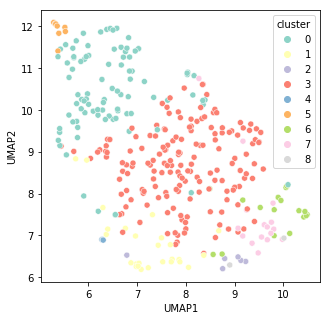

In [6]:
import sklearn.cluster
# from sklearn.manifold import TSNE
# embedding2 = TSNE( 
#                       random_state = 7).fit_transform(grped.loc[:,grped.columns.isin(ch3_feats)]) # 




X = grped.loc[:,grped.columns.isin(ch3_feats)]
clustering = sklearn.cluster.MiniBatchKMeans(n_clusters = 9, n_init = 100, max_iter = 1000, random_state = 7).fit(X)

dfu = pd.concat([pd.DataFrame(embedding),grped.gene_symbol,pd.Series(clustering.labels_)],axis = 1)
dfu.columns = ['UMAP1','UMAP2','gene_symbol','cluster']

plt.figure(figsize = (5,5))
sns.scatterplot(data = dfu, x = 'UMAP1',  y = 'UMAP2', hue = 'cluster', palette = 'Set3')

plt.savefig('/home/rcarlson/mountb/M57/process/figs/ch3_clust.tif', dpi = 100, bbox_inches = 'tight')

In [33]:
clustergenes

{'AGAP5',
 'BOD1L1',
 'CABIN1',
 'COG7',
 'CSNK2A1',
 'FAR1',
 'FIBP',
 'LMNA',
 'LMNB1',
 'MCL1',
 'PAGR1',
 'PAXIP1',
 'PIP4K2C',
 'RAPGEF1',
 'RBL1',
 'SELENOI',
 'SNX13',
 'SNX14',
 'SS18',
 'STAG2',
 'STAT3',
 'TMEM209',
 'TRIP12',
 'UBAP2L',
 'VPS11',
 'VPS16'}

In [70]:
tmp[tmp.preferredName_B.isin(clustergenes)].iloc[:,6:-1].sum(axis=1).sum(axis = 0)#.iloc[:,6:-1].sum(axis=1)

4.881

/home/rcarlson/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


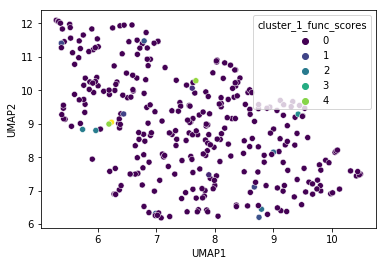

In [98]:
tmp2 = dfu.iloc[:327,:]
tmp2['cluster_1_func_scores'] = scores#
#tmp2['cluster_1_func_scores'] = tmp2['cluster_1_func_scores'].astype('float32')
sns.scatterplot(data = tmp2, x = 'UMAP1',  y = 'UMAP2', hue = 'cluster_1_func_scores', palette = 'viridis', vmin = 0, vmax = .0001)



In [128]:
import requests, io

def get_homology(identifiers, species=9606, caller_identity='https://github.com/gpp-rnd/stringdb',
                              ):
    """Get all pathways for a list of string ids
    Parameters
    ----------
    identifiers: list
        list of string ids
    species: int, optional
        species NCBI identifier
    caller_identity: str, optional
        personal identifier for string
    allow_pubmed: int, optional
        include pubmed articles, options - 1 or 0
    Returns
    -------
    DataFrame
        mapping between string ids and gene pathways
    """
    request_url = build_request_url("homology")
    pathway_list = []
    print(len(identifiers))
    # limited to 2000 queries by string
    #for i in range(0, len(identifiers)):
    curr_ids = identifiers
    # print(curr_ids)
    # print(identifiers)
    params = {
        "identifiers": "%0d".join(curr_ids.queryItem),  # protein list
        "species": species,
        "caller_identity": caller_identity,
    }
    # print(params)
    results = requests.post(request_url, data=params)

    df = handle_results(results)
    # print(df)
    pathway_list.append(df)
    pathway_df = pd.concat(pathway_list)
    return pathway_df

def build_request_url(method, output_format='tsv'):
    """Create url to query the string database
    Allows us to create stubs for querying the string api with various methods
    Parameters
    ----------
    method: str
        options - get_string_ids, network, interaction_partners, homology, homology_best,
            enrichment, functional_annotation, ppi_enrichment, version
    output_format: str, optional
        options - tsv, tsv-non-header, json, xml
    Returns
    -------
    str
        request URL
    """
    string_api_url = "https://string-db.org/api"
    request_url = "/".join([string_api_url, output_format, method])
    return request_url


def handle_results(results):
    """Handle results returned from string"""
    if results.ok:
        data = results.content.decode('utf8')
        # assumes tsv input
        df = pd.read_csv(io.StringIO(data), sep='\t')
        return df
    else:
        raise ValueError(results.reason)



get_homology(stringdb.get_string_ids(['CDK1','CDK2','CDK3']))

3


,ncbiTaxonId_A,stringId_A,ncbiTaxonId_B,stringId_B,bitscore
0,9606,9606.ENSP00000266970,9606,9606.ENSP00000266970,616.3
1,9606,9606.ENSP00000266970,9606,9606.ENSP00000378699,406.8
2,9606,9606.ENSP00000378699,9606,9606.ENSP00000266970,406.8
3,9606,9606.ENSP00000266970,9606,9606.ENSP00000410561,478.0
4,9606,9606.ENSP00000410561,9606,9606.ENSP00000266970,478.0
5,9606,9606.ENSP00000378699,9606,9606.ENSP00000378699,612.1
6,9606,9606.ENSP00000378699,9606,9606.ENSP00000410561,406.0
7,9606,9606.ENSP00000410561,9606,9606.ENSP00000378699,406.0
8,9606,9606.ENSP00000410561,9606,9606.ENSP00000410561,630.2


In [129]:
homol = get_homology(stringdb.get_string_ids(list(dfu.gene_symbol)))

339


In [133]:
stringids = stringdb.get_string_ids(list(dfu.gene_symbol))

In [137]:
homol.head()

,ncbiTaxonId_A,stringId_A,ncbiTaxonId_B,stringId_B,bitscore
0,9606,9606.ENSP00000029410,9606,9606.ENSP00000029410,689.1
1,9606,9606.ENSP00000040738,9606,9606.ENSP00000040738,6176.3
2,9606,9606.ENSP00000157812,9606,9606.ENSP00000157812,854.7
3,9606,9606.ENSP00000162749,9606,9606.ENSP00000162749,928.3
4,9606,9606.ENSP00000188312,9606,9606.ENSP00000188312,823.9


In [153]:
homol2 = homol[~(homol.stringId_B == homol.stringId_A)]
homol3 = pd.merge(stringids[['queryItem','stringId']],homol2, how = 'right', left_on = 'stringId', right_on = 'stringId_A', 
         )
homol4 = pd.merge(stringids[['queryItem','stringId']],homol3, how = 'right', left_on = 'stringId', right_on = 'stringId_B', 
         suffixes = ('_B','_A'))

#


In [176]:
homol4[homol4.queryItem_A == "ATP2B1"]#.queryItem_B.tolist()

,queryItem_B,stringId_B,queryItem_A,stringId_A,ncbiTaxonId_A,stringId_A,ncbiTaxonId_B,stringId_B,bitscore
161,ATP13A1,9606.ENSP00000349877,ATP2B1,9606.ENSP00000392043,9606,9606.ENSP00000392043,9606,9606.ENSP00000349877,65.9
236,ATP2C1,9606.ENSP00000421326,ATP2B1,9606.ENSP00000392043,9606,9606.ENSP00000392043,9606,9606.ENSP00000421326,289.3


In [168]:
homol4.groupby('queryItem_A').count().sort_values('bitscore',ascending = False)[:50]

,queryItem_B,stringId_B,stringId_A,ncbiTaxonId_A,stringId_A,ncbiTaxonId_B,stringId_B,bitscore
queryItem_A,,,,,,,,
PRDM1,11,11,11,11,11,11,11,11
ZNF43,11,11,11,11,11,11,11,11
ZNF274,11,11,11,11,11,11,11,11
ZNF699,10,10,10,10,10,10,10,10
ZNF667,10,10,10,10,10,10,10,10
ZNF610,10,10,10,10,10,10,10,10
ZNF285,10,10,10,10,10,10,10,10
ZNF740,9,9,9,9,9,9,9,9
ZNF276,9,9,9,9,9,9,9,9


/home/rcarlson/miniconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/rcarlson/miniconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/rcarlson/miniconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until ex

/home/rcarlson/miniconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/rcarlson/miniconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/rcarlson/miniconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until ex

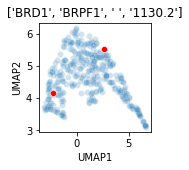

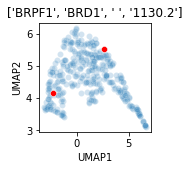

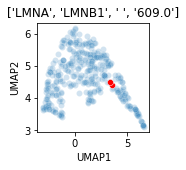

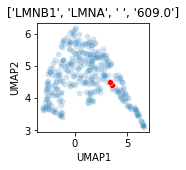

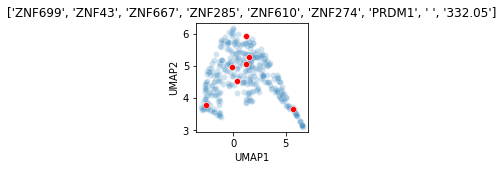

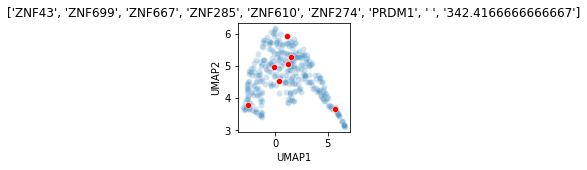

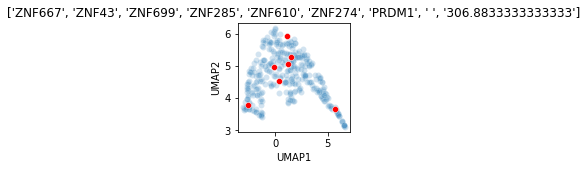

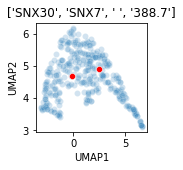

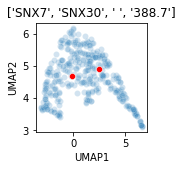

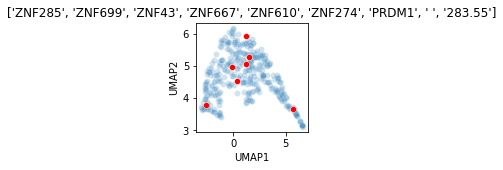

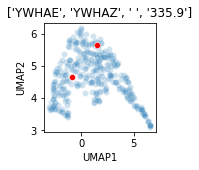

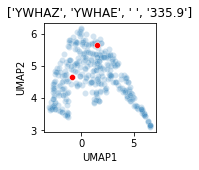

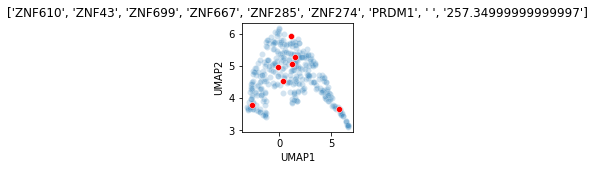

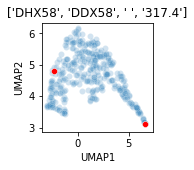

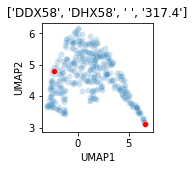

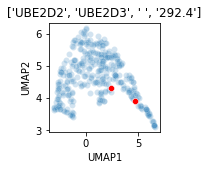

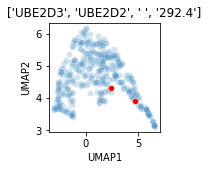

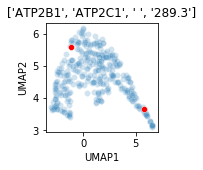

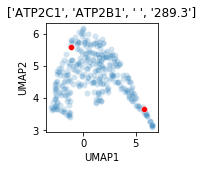

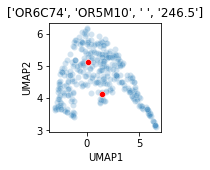

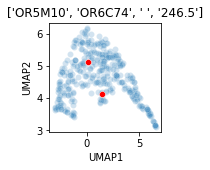

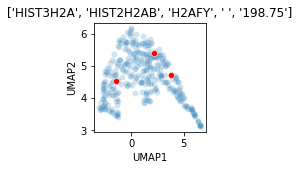

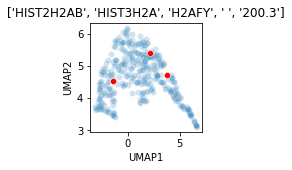

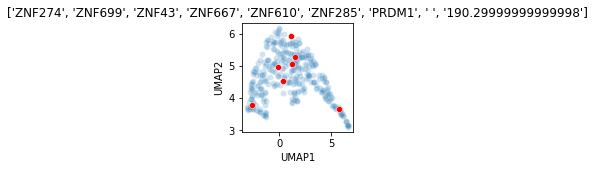

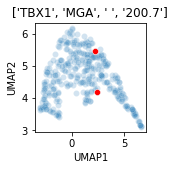

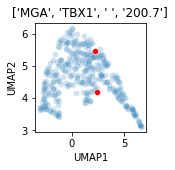

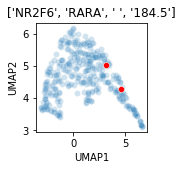

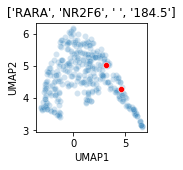

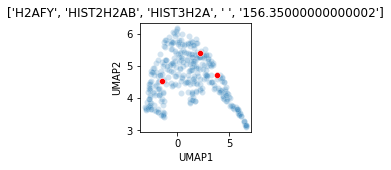

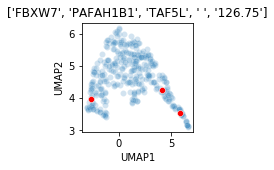

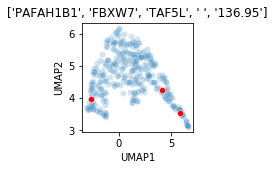

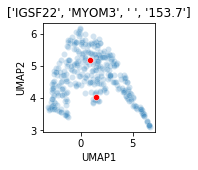

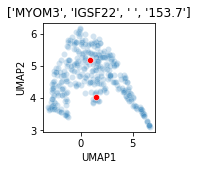

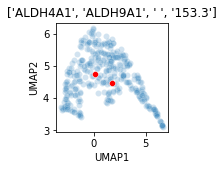

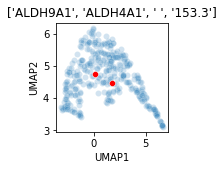

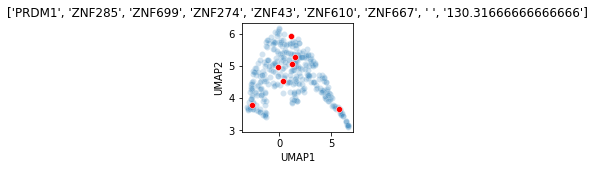

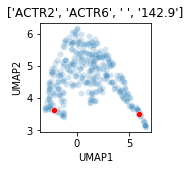

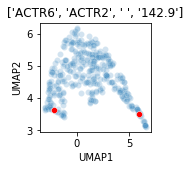

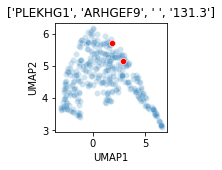

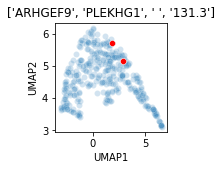

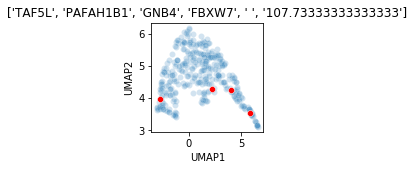

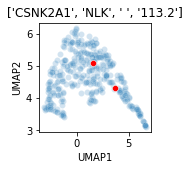

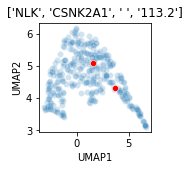

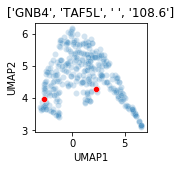

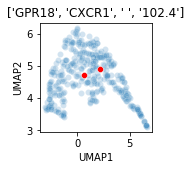

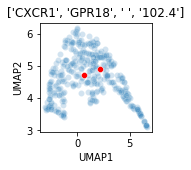

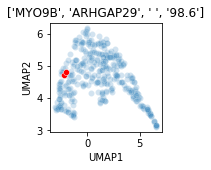

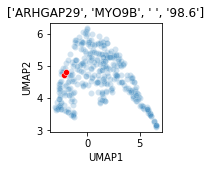

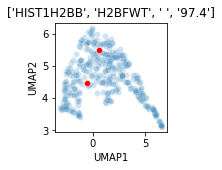

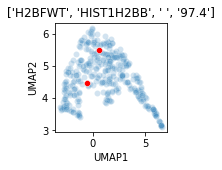

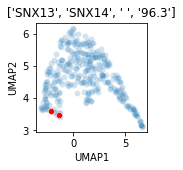

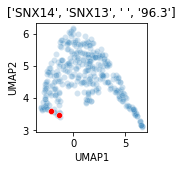

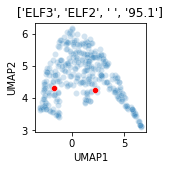

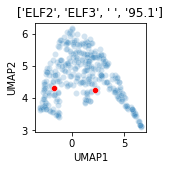

In [197]:


#genes = dfu[(dfu.UMAP1 < 6) & (dfu.UMAP2 < 1)].gene_symbol
# sns.scatterplot(data = dfu[dfu.gene_symbol.isin(genes)], x = 'UMAP1', 
#                     y = 'UMAP2', color = 'k')#,   legend = 'full', hue = 'gene_symbol')

# downgenes = ['MAVS','DDX58', 'IRF3', 'IRF2', 'ATP13A1','RNF135']

embedding = umap.UMAP(n_neighbors=20,
                      min_dist=0.01,
                      metric='euclidean', random_state = 7).fit_transform(grped.iloc[:,3:]) # 





dfu = pd.concat([pd.DataFrame(embedding),grped.gene_symbol],axis = 1)
dfu.columns = ['UMAP1','UMAP2','gene_symbol']




thresh = 95
homol4 = homol4.sort_values('bitscore',ascending = False)
for gene in pd.unique(homol4[homol4.bitscore > thresh].queryItem_A):
    
    homolgenes = homol4[(homol4.queryItem_A == gene) & (homol4.bitscore > thresh)].queryItem_B.tolist()
    plt.figure(figsize = (2,2))
    #print(gene)
    sns.scatterplot(data = dfu, x = 'UMAP1',  y = 'UMAP2', alpha = .2)
    meanscore = homol4[(homol4.queryItem_A == gene) & (homol4.bitscore > thresh)].bitscore.mean()
    plt.title([gene]+homolgenes + [' ', str(meanscore)])
    sns.scatterplot(data = dfu[dfu.gene_symbol.isin([gene]+homolgenes)], x = 'UMAP1', 
                    y = 'UMAP2', color = 'r')#,   legend = 'full', hue = 'gene_symbol')

    plt.savefig('/home/rcarlson/mountb/M57/process/figs/homologs_%s.tif'%(gene), dpi = 100, bbox_inches = 'tight')
    
    

,ncbiTaxonId_A,stringId_A,ncbiTaxonId_B,stringId_B,bitscore
5,9606,9606.ENSP00000188312,9606,9606.ENSP00000367220,142.9
6,9606,9606.ENSP00000367220,9606,9606.ENSP00000188312,142.9
10,9606,9606.ENSP00000216267,9606,9606.ENSP00000373340,1130.2
11,9606,9606.ENSP00000373340,9606,9606.ENSP00000216267,1130.2
14,9606,9606.ENSP00000217244,9606,9606.ENSP00000384625,113.2
...,...,...,...,...,...
583,9606,9606.ENSP00000467723,9606,9606.ENSP00000464788,387.5
584,9606,9606.ENSP00000464788,9606,9606.ENSP00000478533,182.2
585,9606,9606.ENSP00000478533,9606,9606.ENSP00000464788,182.2
590,9606,9606.ENSP00000467723,9606,9606.ENSP00000478533,214.2


In [71]:
#for cluster in pd.unique(dfu.cluster):
cluster = 1
print(cluster)
clustergenes = set(dfu[dfu.cluster == cluster].gene_symbol)
scores = []
for gene in pd.unique(dfu.gene_symbol):
    print(gene)
    tmp = stringdb.get_interaction_partners(stringdb.get_string_ids([gene]).queryItem)
    if tmp[tmp.preferredName_B.isin(clustergenes)].iloc[:,6:-1].sum(axis=1).shape[0] == 0:
        scores.append(0)
    else:
        print(float(tmp[tmp.preferredName_B.isin(clustergenes)].iloc[:,6:-1].sum(axis=1).sum(axis=0)))
        scores.append(float(tmp[tmp.preferredName_B.isin(clustergenes)].iloc[:,6:-1].sum(axis=1).sum(axis=0)))
    #print(scores)
    #tmp[tmp.preferredName_B.isin(clustergenes)]

1
ACHE
ACOT11
ACTR2
ACTR6
ADNP
AFF4
AGAP5
AHR
AKAP13
AKIRIN1
ALDH4A1
ALDH9A1
ALG1L2
ANP32B
APOC4
APOL6
AQP12A
ARHGAP29
ARHGAP32
ARHGEF9
ARMC9
ARNT
ARRB1
ASB12
ASB7
ASPM
ASXL1
ATAD5
ATP13A1
ATP2B1
ATP2C1
ATP5PF
ATXN7L2
AUH
B3GALT6
B4GALT7
BBS5
BLOC1S1
BMP5
BOD1L1
BRD1
BRMS1
BRPF1
BTAF1
BTN2A2
C1orf100
C1orf174
C22orf46
C4A
C4BPA
C6orf62
CAB39
CABIN1
CACNA1F
CALML6
CAPN15
CASTOR2
CAVIN1
CBARP
CCDC112
CCDC130
CCNC
CERS2
CHAMP1
CHCHD1
CHRFAM7A
CLIC1
CLVS2
CMAS
CNKSR1
COG7
COL6A3
COMMD3
COPRS
COPS4
COPS7A
CRELD1
CSNK2A1
CSTF2T
CXCR1
CXorf65
DCAF4L1
DDX31
DDX58
DEFB107B
DHX29
DHX58
DIS3L
DISP2
DPF2
0.97
DPH6
DROSHA
E2F7
0.5329999999999999
ECM1
EHMT1
EIF3G
ELF2
ELF3
ENTPD4
EPG5
EPS8L1
FAAH
FAM129B
FAM153B
FAM189A2
FAM217B
FAM24B
FANCL
FAR1
FBXO11
FBXO34
FBXW7
FCER1A
FERMT2
FIBP
FKBPL
FLCN
FREM1
FZD9
FZR1
GAL3ST1
GJA4
GNB4
GNE
GPR18
GPS2
GRASP
H2AFY
H2BFWT
HDAC1
HINFP
HIPK2
HIST1H2BB
HIST2H2AB
HIST3H2A
HMG20B
HNRNPF
HOXD1
HS6ST1
HTN1
HTT
IGSF22
IKBKG
IMMP1L
IRF2
IRF3
JUNB
KLHL15
KNCN
KYAT1
LAM

ValueError: Bad Request

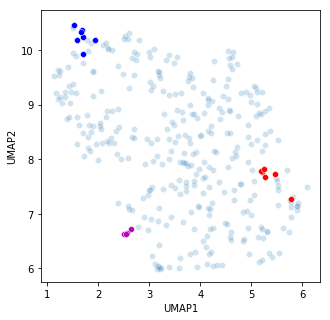

In [239]:
embedding = umap.UMAP(n_neighbors=20,
                      min_dist=0.01,
                      metric='euclidean', 
                      random_state = 7).fit_transform(grped.loc[:,grped.columns.isin(ch3_feats)]) # 





dfu = pd.concat([pd.DataFrame(embedding),grped.gene_symbol],axis = 1)
dfu.columns = ['UMAP1','UMAP2','gene_symbol']


## much better than below since this is channel 3 only 
plt.figure(figsize = (5,5))
sns.scatterplot(data = dfu, x = 'UMAP1',  y = 'UMAP2', alpha = .2)
#genes = dfu[(dfu.UMAP1 < 6) & (dfu.UMAP2 < 1)].gene_symbol
# sns.scatterplot(data = dfu[dfu.gene_symbol.isin(genes)], x = 'UMAP1', 
#                     y = 'UMAP2', color = 'k')#,   legend = 'full', hue = 'gene_symbol')

downgenes = ['MAVS','DDX58', 'IRF3', 'IRF2', 'ATP13A1','RNF135']

sns.scatterplot(data = dfu[dfu.gene_symbol.isin(downgenes)], x = 'UMAP1', 
                    y = 'UMAP2', color = 'r')#,   legend = 'full', hue = 'gene_symbol')




sevgenes = ['SLC35A1','GNE','CMAS','COG7']#,'CAPN15','MED16','MED24','TADA2B','MAU2']
sns.scatterplot(data = dfu[dfu.gene_symbol.isin(sevgenes)], x = 'UMAP1', 
                    y = 'UMAP2', color = 'm')#,   legend = 'full', hue = 'gene_symbol')


upgenes = ['MED16', 'MED24', 'MAU2', 'LAMTOR2', 'LAMTOR3', 'LAMTOR4', 'TADA2B']#,'CAPN15','MED16','MED24','TADA2B','MAU2']
sns.scatterplot(data = dfu[dfu.gene_symbol.isin(upgenes)], x = 'UMAP1', 
                    y = 'UMAP2', color = 'b')#,   legend = 'full', hue = 'gene_symbol')


plt.savefig('/home/rcarlson/mountb/M57/process/figs/ch3_naive.tif', dpi = 100, bbox_inches = 'tight')